In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import geopandas as gpd
import math
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import json
import matplotlib.cm as cm
from tqdm import tqdm
from datetime import datetime
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch

today = datetime.today().strftime('%Y%m%d')
today

'20250718'

In [2]:
scout_result_date = '062725'

In [4]:
ref = pd.read_csv(r'capital_cost_table\ref_annual_CAPX.csv')
AEO = pd.read_csv(r'capital_cost_table\aeo_annual_CAPX.csv')
state = pd.read_csv(r'capital_cost_table\state_annual_CAPX.csv')
fossil = pd.read_csv(r'capital_cost_table\fossil_annual_CAPX.csv')
brk = pd.read_csv(r'capital_cost_table\brk_annual_CAPX.csv')
accel = pd.read_csv(r'capital_cost_table\accel_annual_CAPX.csv')
# add sector and scenario
def extract_sector(df):
    df['sector'] = df['meas'].str.extract(r'\((R|C)\)')[0].map({'R': 'Residential', 'C': 'Commercial'})
    return df

ref = extract_sector(ref)
AEO = extract_sector(AEO)
state = extract_sector(state)
fossil = extract_sector(fossil)
brk = extract_sector(brk)
accel = extract_sector(accel)
ref['scenario'] = 'Reference'
AEO['scenario'] = 'AEO 2023 w/ BTB'
state['scenario'] = 'State and Local Action'
fossil['scenario'] = 'Fossil Favorable'
brk['scenario'] = 'Breakthrough'
accel['scenario'] = 'Accelerate'
cost_all_scenario = pd.concat([AEO, ref, state, fossil, brk, accel], ignore_index=True)

In [7]:
cost_all_scenario_grouped = (cost_all_scenario.groupby(['year', 'scenario','metric'])['value'].sum().reset_index())
cost_all_scenario_grouped.head(2)

,year,scenario,metric,value
0,2024,AEO 2023 w/ BTB,Incremental Measure Stock Cost (2024$),0.0
1,2024,AEO 2023 w/ BTB,Total Measure Stock Cost (2024$),0.0


# 1. Line plots for 3 cost metrics

In [14]:
# ----------------------------------------------- #
# ------------ CHANGE METRICS HERE -------------- # 
# ----------------------------------------------- #

metric_to_plot = 'Total Measure Stock Cost (2024$)'
# metric_to_plot = 'Incremental Measure Stock Cost (2024$)' 

sub_table = cost_all_scenario_grouped[cost_all_scenario_grouped['metric']==metric_to_plot]
if metric_to_plot == 'Efficient Energy Cost (USD)':
    sub_table = pd.concat([sub_table, AEO_baseline], ignore_index=True)
pivot = sub_table.pivot_table(
    index='year',
    columns=['scenario'],
    values='value'
)
pivot = pivot/1e9
pivot.head(2)

scenario,AEO 2023 w/ BTB,Accelerate,Breakthrough,Fossil Favorable,Reference,State and Local Action
year,,,,,,
2024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2026,566.922783,562.914417,562.914417,494.350406,543.039449,559.609965


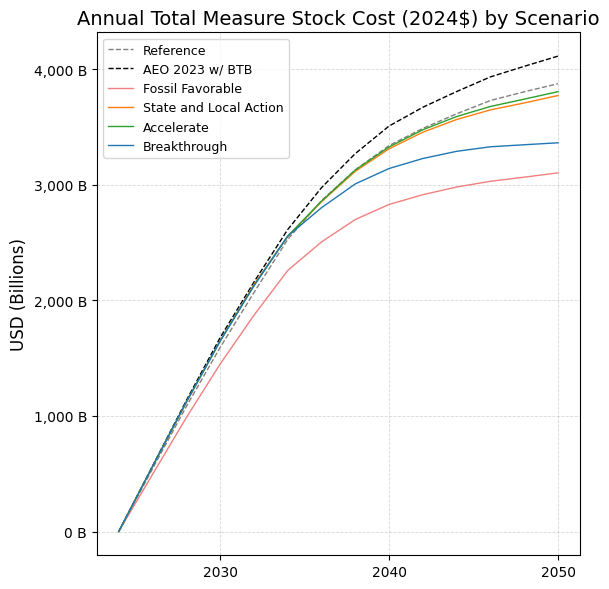

In [15]:
# Define fixed colors for each scenario
scenario_colors = {
    'Reference':'grey',
    'AEO 2023 w/ BTB':'black',
    # 'AEO 2023 Baseline': 'red',
    'Fossil Favorable': 'lightcoral',
    'State and Local Action': 'tab:orange',
    'Accelerate': 'tab:green',
    'Breakthrough': 'tab:blue',
}
pivot = pivot.reindex(columns=list(scenario_colors.keys()))
pivot

fig, ax = plt.subplots(figsize=(6,6))
for scenario in pivot.columns:    
    color = scenario_colors[scenario]
    linestyle = '--' if scenario.lower() in ['reference', 'aeo 2023 w/ btb'] else '-'
    linewidth = 2 if scenario == 'AEO 2023 Baseline' else 1
    ax.plot(
        pivot.index,
        pivot[scenario],
        label=scenario,
        color=color,
        linewidth=linewidth,
        linestyle=linestyle
    )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='', fontsize=9)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f} B'))
ax.grid(visible=True, linestyle='--', linewidth=0.6, alpha=0.5)
ax.set_xticks([y for y in pivot.index if y % 5 == 0 and y >= 2025])
ax.set_ylabel("USD (Billions)", fontsize=12)

metric_for_title = metric_to_plot.replace(' (USD)', '')
title = f"Annual {metric_for_title} by Scenario"
# if metric_to_plot =='Cost Savings (USD)':
#     title = f"Energy Cost Savings vs. AEO 2023" 
ax.set_title(title, fontsize=14)
plt.tight_layout()
plt.savefig(f'cost_graph_capital/{title}_{today}.png', transparent=False, bbox_inches='tight')

# 2. Stack plot for cost savings by measures

## 2.1 breakdown by sector 

In [17]:
cost_all_scenario['scenario'].unique()

array(['AEO 2023 w/ BTB', 'Reference', 'State and Local Action',
       'Fossil Favorable', 'Breakthrough', 'Accelerate'], dtype=object)

In [120]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_area_for_all_sectors(df, state, prefix, ymin, ymax):
    scenarios = ['AEO 2023 w/ BTB', 'Fossil Favorable', 'Reference', 'State and Local Action', 'Accelerate', 'Breakthrough']
    res_color = 'tab:orange'  #  orange 
    com_color = 'tab:blue'  #  blue

    fig, axes = plt.subplots(3, 2, figsize=(10,12), sharex=True)
    axes = axes.flatten()

    skipped_total = 0  # To accumulate skipped negative values

    for i, scenario in enumerate(scenarios):
        ax = axes[i]

        if state == 'All States':
            sub_df = df[df['scenario'] == scenario]  # no state filtering
        else:
            sub_df = df[(df['scenario'] == scenario) & (df['reg'] == state)]

        if sub_df.empty:
            ax.set_title(f"{scenario}\n(No Data)")
            ax.axis('off')
            continue

        # Group and pivot
        pivot_df = sub_df.groupby(['year', 'sector'])['value'].sum().unstack(fill_value=0)
        # pivot_df = sub_df.groupby(['year'])['value'].sum()
        pivot_df /= 1e9  # Convert to billions
        pivot_df = pivot_df.sort_index()
        if scenario =='Fossil':
            pivot_df_save = pivot_df
        
        desired_order = [ 'Commercial', 'Residential']
        pivot_df = pivot_df[desired_order]
        # pivot_df.plot(ax=ax, kind='line', color=[com_color, res_color], linewidth=2, legend=False)
        # pivot_df.plot(ax=ax, kind='line', color='black', linewidth=2, legend=False)
        # Sum the two columns into one
        pivot_df['Total'] = pivot_df['Commercial'] + pivot_df['Residential']
        
        pivot_df[['Commercial']].plot(
            ax=ax,
            kind='line',
            linewidth=1.5,
            color=[com_color],
            legend=False  # or False, depending on your preference
        )
        
        # Now plot total on top for emphasis
        pivot_df['Total'].plot(ax=ax, color='tab:orange', linewidth=2, label='Total')
        # Fill area below Commercial
        ax.fill_between(pivot_df.index, 0, pivot_df['Commercial'], color='tab:blue', alpha=0.5, label='Commercial Area')
        
        # # Fill area between Commercial and Total (i.e., Residential contribution)
        # ax.fill_between(pivot_df.index, pivot_df['Commercial'], pivot_df['Total'], color='tab:orange', alpha=0.5, label='Residential Area')

        # Compute Residential component
        res_contrib = pivot_df['Total'] - pivot_df['Commercial']
        
        # For the residential fill:
        # Case 1: Commercial ≥ 0 → fill between Commercial and Total
        # Case 2: Commercial < 0 → only fill where Total > 0
        res_y0 = np.where(pivot_df['Commercial'] >= 0, pivot_df['Commercial'], 0)
        res_y1 = np.where(
            (pivot_df['Commercial'] >= 0), 
            pivot_df['Total'], 
            np.where(pivot_df['Total'] > 0, pivot_df['Total'], 0)
        )
        
        ax.fill_between(pivot_df.index, res_y0, res_y1, color=res_color, alpha=0.5, label='Residential Area')
        ax.set_ylim(ymin, ymax)

        # Final touches
        ax.axhline(0, color='black', linewidth=3)
        ax.grid(linestyle='--',alpha=0.5)
        ax.set_title(scenario)
        ax.set_ylabel(f"{prefix} ($B)")
        ax.set_xlim(2024, 2050)
        ax.set_xticks(np.arange(2025, 2051, 5))
        ax.set_xticklabels([str(year) for year in range(2025, 2051, 5)])
        ax.set_xlabel("Year")

    
    # Shared legend
    legend_handles = [
        Patch(facecolor=res_color, edgecolor=res_color, linewidth=1.5, label='Residential', alpha=0.5),
        Patch(facecolor=com_color, edgecolor=com_color, linewidth=1.5, label='Commercial', alpha=0.5)
    ]
    fig.legend(handles=legend_handles, loc='lower center', ncol=2, title='Sector')
    
    fig.suptitle(f"{prefix} by Scenario, {state}", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(f'cost_graph_capital/{prefix} {state}.png',transparent=False, bbox_inches='tight')
    # plt.close()
    return sub_df, pivot_df

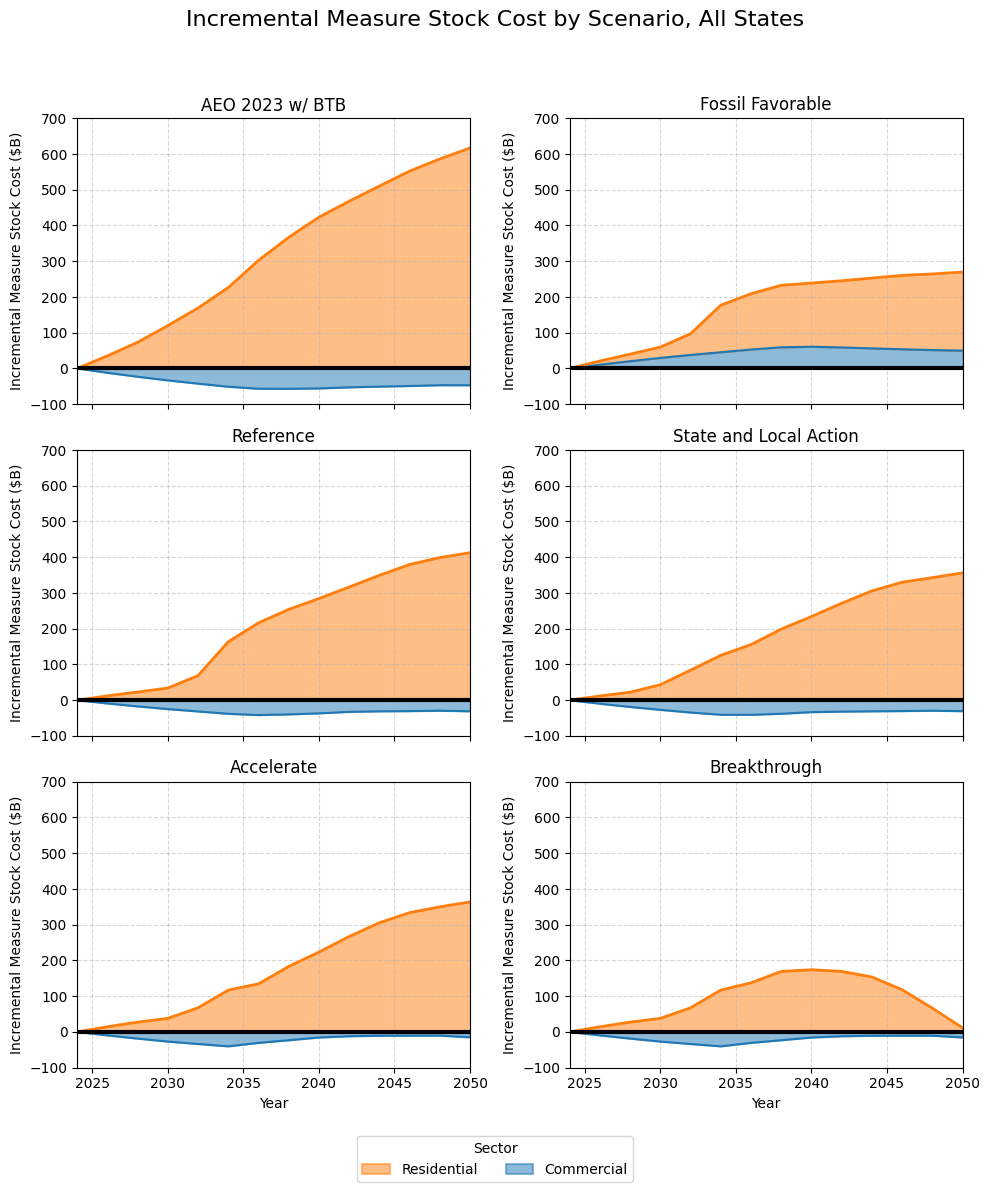

In [122]:
# scenario option: 'Reference', 'AEO', 'State Policies', 'Fossil', 'Breakthrough', 'Accelerate'
state = 'All States' 
# metric_to_plot = 'Total Measure Stock Cost (2024$)'
# ymax = 4500

metric_to_plot = 'Incremental Measure Stock Cost (2024$)' 
ymax=700

sub_table = cost_all_scenario[cost_all_scenario['metric']==metric_to_plot]
pivot = sub_table.pivot_table(
    index='year',
    columns=['scenario'],
    values='value'
)
prefix=metric_to_plot.split(' (')[0]
pivot = pivot/1e9
pivot.head(2)
sub_df, pivot_df = plot_stacked_area_for_all_sectors(sub_table, state, prefix, ymin=-100, ymax=ymax)

## 2.2 breakdown by measures

In [75]:
def plot_stacked_cost_savings(df,ymin, ymax, color_map):
    bar_width = 0.6
    sub_df = df[df['year'].isin([2030, 2040, 2050])].copy()

    if sub_df.empty:
        print("No data for given state and scenario.")
        return

    pivot_df = sub_df.pivot_table(
        index='year',
        columns='meas',
        values='value',
        aggfunc='sum'
    ).fillna(0)
    pivot_df /= 1e9
    meas_totals = pivot_df.sum()
    top_n = 9
    sorted_measures = meas_totals.abs().sort_values(ascending=False)
    plotted_measures = sorted_measures.head(top_n).index.tolist()
    plotted_measures_set.update(plotted_measures)
    
    other_measures = sorted_measures.index.difference(plotted_measures)
    
    # Create an "Other" column by summing everything else
    pivot_df['All other measures'] = pivot_df[other_measures].sum(axis=1)
    

    # Sample from rainbow colormap
    cmap = plt.get_cmap('rainbow')
    n_colors = len(plotted_measures_set) # 3 scneraios x 9 measures
    
    for i, meas in enumerate(plotted_measures):
        if meas not in color_map:
            color_map[meas] = mcolors.to_hex(cmap(i / max(n_colors - 1, 1)))  # Normalize to [0, 1]
    color_map['All other measures'] = 'lightgrey'

    final_measures = plotted_measures + ['All other measures']
    color_list = [color_map[meas] for meas in final_measures]


    
    # Plot
    fig, ax = plt.subplots(figsize=(5,7))

    # Stacked positive
    pivot_df = pivot_df[final_measures]
    pivot_df.plot(kind='bar', stacked=True, ax=ax, legend=False, color=color_list, width=bar_width, alpha=0.6)

    # Label total on top
    totals = pivot_df.sum(axis=1)
    
    # Find highest and lowest values (positive or negative)
    max_year = totals.idxmax()
    min_year = totals.idxmin()
    
    max_val = totals[max_year]
    min_val = totals[min_year]
    
    print(f"Highest total cost savings: ${max_val:,.2f}B in {max_year}")
    print(f"Lowest total cost savings (most negative): ${min_val:,.2f}B in {min_year}")

    for i, (year, total) in enumerate(totals.items()):
        label = f"${total:,.2f}B"
        # label = (
        #     f"${total/1e9:,.0f}B" if abs(total) > 1e9 
        #     else f"${total/1e6:,.0f}M" if abs(total) > 1e6 
        #     else f"${total:,.0f}"
        # )
        y = pivot_df.loc[year].sum()
        print(pivot_df.loc[year].sum())
        gap = 0.1
        ax.annotate(label,  xy = (i, y), 
                    xytext=(0, 10 if y > 0 else -10), 
                    textcoords='offset points', 
                    ha='center', va='bottom' if y > 0 else 'top', 
                    fontsize=10)
        ax.hlines(y, i - bar_width/2, i + bar_width/2, colors='tab:green', linestyles='--', linewidth=2)

    # if 'residential' in title.lower():
    #     title_norm_explain = '# new homes'
    # else:
    #     title_norm_explain = 'total square footage'
    
    ax.set_ylabel(f"Cost Savings ($B)")
    ax.set_xlabel("Year")
    ax.axhline(0, color='black', linewidth=2)

    # ymin, ymax = ax.get_ylim()
    # buffer = (ymax - ymin) * 0.1
    # ax.set_ylim(ymin - buffer, ymax)
    ax.set_ylim(ymin, ymax)

    # Get legend handles and labels from both plot calls
    handles, labels = ax.get_legend_handles_labels()
    
    # Keep only entries that match the filtered measures and are not duplicates
    seen = set()
    filtered = []
    for h, l in zip(handles, labels):
        if l in final_measures and l not in seen:
            filtered.append((h, l))
            seen.add(l)
    
    # Sort by absolute impact
    sorted_measures = meas_totals.loc[plotted_measures].abs().sort_values(ascending=False).index.tolist()
    sorted_measures.append('All other measures')
    # filtered.sort(key=lambda x: sorted_measures.index('All other measures' if x[1] == 'All other measures' else x[1]))
    filtered.sort(key=lambda x: 999 if x[1] == 'All other measures' else sorted_measures.index(x[1]))


    # aesthetics
    # Remove all spines except left (y-axis)
    for spine in ['top', 'right', 'bottom']:
        ax.spines[spine].set_visible(False)
    # Keep only left spine (y-axis)
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.grid(axis='y', alpha=0.5, linestyle='--')
    ax.tick_params(axis='x', bottom=False)
    ax.tick_params(axis='y', which='both', direction='out')
    # filtered legend
    if filtered:
        handles, labels = zip(*filtered)
        handles, labels = handles[::-1], labels[::-1]
        fig.legend(
            handles,
            labels,
            loc='upper center',
            bbox_to_anchor=(0.5, 0), 
            title='Measure',
            ncol=1,
            frameon=True
        )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  
    # if enduse == 'all':
        
    # ax.set_title(f"{sector}, {enduse}")
    ax.set_title(f"{sector}")
    plt.suptitle(f'{scenario} {prefix}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'cost_graph_capital/{prefix} {state} {scenario} {sector}.png', transparent=False, bbox_inches='tight')
    plt.close()
    return sorted_measures

In [76]:
cost_all_scenario.head(2)

,meas,adoption_scn,metric,year,value,sector,scenario
0,(R) Ref. Case Gas Dryer,Max adoption potential,Total Measure Stock Cost (2024$),2024,0.000000e+00,Residential,AEO 2023 w/ BTB
1,(R) Ref. Case Gas Dryer,Max adoption potential,Total Measure Stock Cost (2024$),2026,2.448201e+09,Residential,AEO 2023 w/ BTB


In [89]:
# scenario option: 'Reference', 'AEO 2023 w/ BTB', 'State and Local Action', 'Fossil Favorable', 'Breakthrough', 'Accelerate'
# end use option: 'Heating (Equip.)', 'Cooling (Equip.)', 'All End Uses'
# sector option: 'Residential', 'Commercial'



state = 'All States'
scenarios = ['Reference', 'Fossil Favorable', 'Breakthrough']
sectors = ['Commercial'] 
# ymax = 1000
ymax = 100 # incremental

# sectors = ['Residential'] 
# ymax = 3200 # taotal
# ymax = 800 # incremental

# end_uses = ['Heating (Equip.)', 'Cooling (Equip.)', 'All End Uses']
# end_uses = ['All End Uses']

# scenario option: 'Reference', 'AEO', 'State Policies', 'Fossil', 'Breakthrough', 'Accelerate'
state = 'All States' 
# metric_to_plot = 'Total Measure Stock Cost (2024$)'
metric_to_plot = 'Incremental Measure Stock Cost (2024$)' 

df_to_plot = cost_all_scenario[cost_all_scenario['metric']==metric_to_plot]
prefix=metric_to_plot.split(' (')[0]
plotted_measures_set = set()
color_map = {}
for scenario in scenarios:
    for sector in sectors:
        print(f'{prefix}, {scenario}, {sector}')
        # end_use_for_title = enduse.replace(' (Equip.)', '')
        # if enduse != 'All End Uses':
        #     # Apply conditional filtering based on state
        #     sub_df = df_to_plot[
        #         (df_to_plot['end_use'] == enduse) &
        #         (df_to_plot['sector'] == sector) & 
        #         (df_to_plot['scenario'] == scenario)
        #     ]
        #     if state != "All States":
        #         sub_df = sub_df[df_to_plot['reg'] == state]
        #     pivot_df  = plot_stacked_cost_savings(sub_df)
        # else:
        sub_df = df_to_plot[
            (df_to_plot['sector'] == sector) & 
            (df_to_plot['scenario'] == scenario)
        ]
        if state != "All States":
            sub_df = sub_df[df_to_plot['reg'] == state]
        filtered  = plot_stacked_cost_savings(sub_df, ymin=-75, ymax=ymax, color_map=color_map)
len(plotted_measures_set)

Incremental Measure Stock Cost, Reference, Commercial
Highest total cost savings: $-24.96B in 2030
Lowest total cost savings (most negative): $-36.80B in 2040
-24.955485506055858
-36.80482209220302
-30.97776810050126
Incremental Measure Stock Cost, Fossil Favorable, Commercial
Highest total cost savings: $60.78B in 2040
Lowest total cost savings (most negative): $29.47B in 2030
29.4729128658041
60.78422107653469
49.87188978209277
Incremental Measure Stock Cost, Breakthrough, Commercial
Highest total cost savings: $-15.39B in 2050
Lowest total cost savings (most negative): $-26.96B in 2030
-26.9625681736931
-15.620868504462315
-15.391391833885793


13